# EDA

## Loading data & Package import

### Package import

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data

In [4]:
train_url = 's3://wagon-public-datasets/taxi-fare-train.csv'
df = pd.read_csv(train_url, nrows=10000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## Exploration

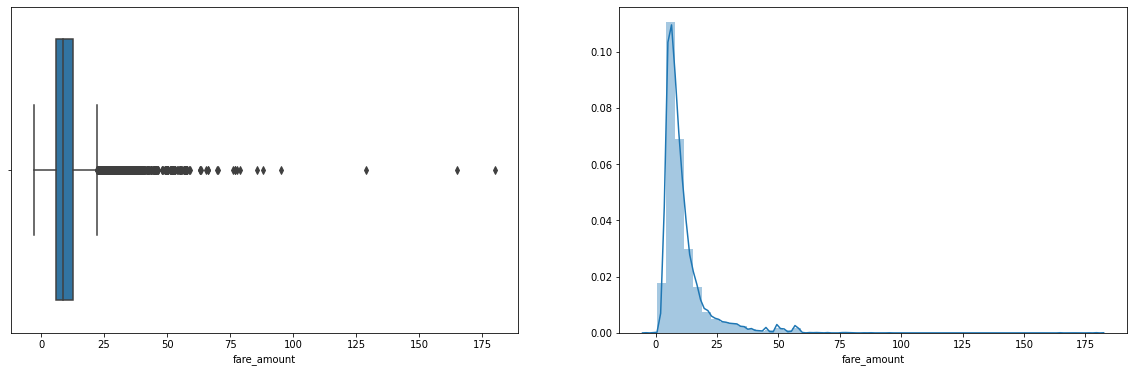

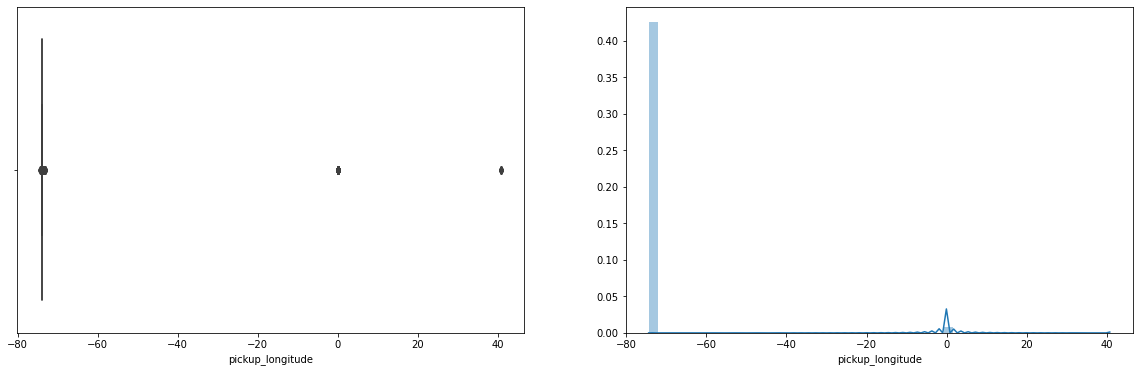

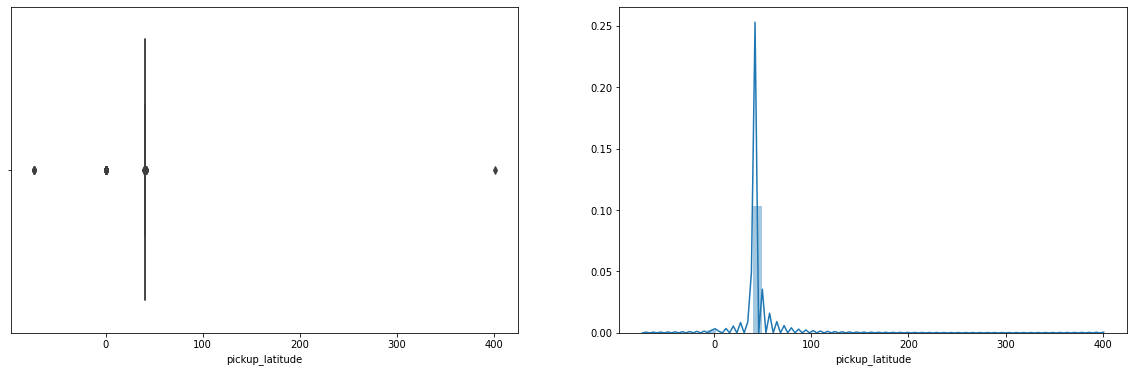

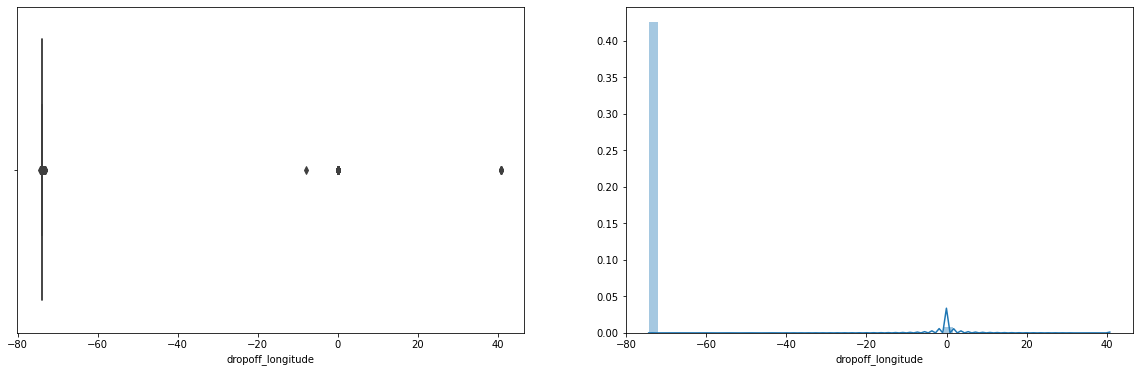

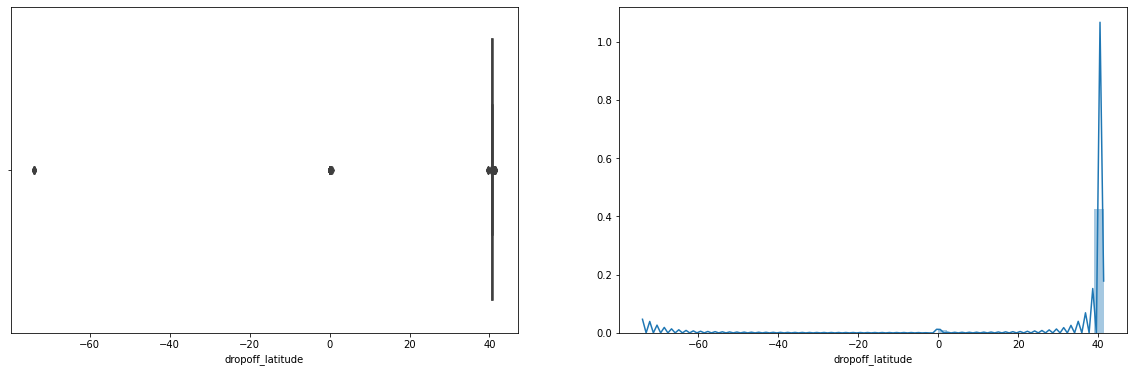

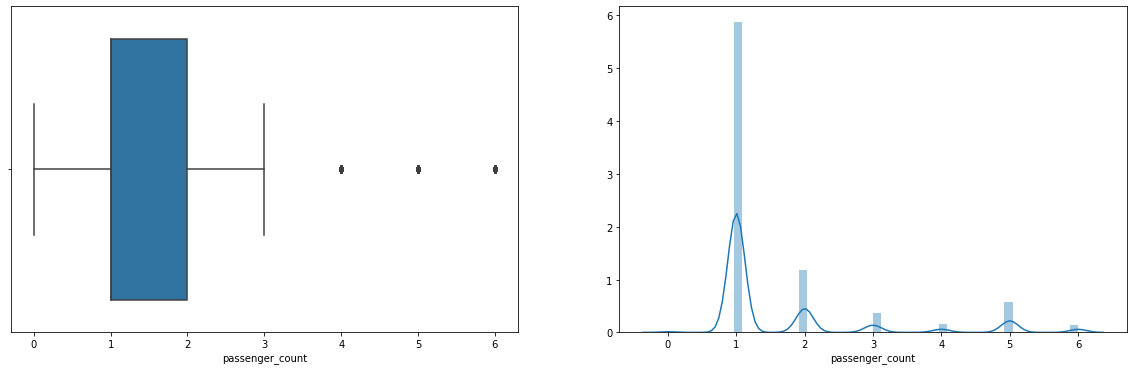

In [8]:
def showme(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    sns.boxplot(df, ax=ax1)
    sns.distplot(df, ax=ax2)

for feat in df.drop(columns=['key', 'pickup_datetime']).columns:
    showme(df[feat])

<h4>Outliers</h4>
<p>Latitude and longitude contain outliers that need to be deleted / dropped. Indeed the outliers represent geographical spots that are hours/days away of NY by car. They are errors.</p> 

<p>Regarding the number of passengers or the fare amount, they seem to be feasible, hence no data cleaning will be performed in this columns.</p>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
key                  10000 non-null object
fare_amount          10000 non-null float64
pickup_datetime      10000 non-null object
pickup_longitude     10000 non-null float64
pickup_latitude      10000 non-null float64
dropoff_longitude    10000 non-null float64
dropoff_latitude     10000 non-null float64
passenger_count      10000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 625.1+ KB


<h4>Objects</h4>
<p>Index and datetime need to be converted to datetime objects.</p> 

In [20]:
pd.DataFrame(pd.to_datetime(df.key)).head()

,key
0,2009-06-15 17:26:21.000000100
1,2010-01-05 16:52:16.000000200
2,2011-08-18 00:35:00.000000490
3,2012-04-21 04:30:42.000000100
4,2010-03-09 07:51:00.000000135
